In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dropout, 
    Dense, BatchNormalization, Input
)
from keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Configurations**


In [2]:
CONFIG = {
    'img_size': (48, 48),
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 0.001,
    'train_dir': 'FER/train',
    'test_dir': 'FER/test',
    'validation_split': 0.2,
}

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

img_size = (48, 48)
batch_size = 32
epochs = 50

**Data import**


In [3]:
# Training data with augmentation AND validation split
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # Data augmentation to combat overfitting and class imbalance
    rotation_range=10,           # Slight head tilt
    width_shift_range=0.1,       # Horizontal shift
    height_shift_range=0.1,      # Vertical shift
    horizontal_flip=True,        # Mirror faces (valid for emotions)
    zoom_range=0.1,              # Slight zoom
    fill_mode='nearest',
    validation_split=0.2         # CRITICAL: 20% for validation
)

# Test data - NO augmentation, only rescaling
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Training generator (80% of training data)
train_generator = train_datagen.flow_from_directory(
    CONFIG['train_dir'],
    target_size=CONFIG['img_size'],
    color_mode='grayscale',
    batch_size=CONFIG['batch_size'],
    class_mode='categorical',
    shuffle=True,
    subset='training',  # Use only training subset
    seed=42
)

# Validation generator (20% of training data)
val_generator = train_datagen.flow_from_directory(
    CONFIG['train_dir'],
    target_size=CONFIG['img_size'],
    color_mode='grayscale',
    batch_size=CONFIG['batch_size'],
    class_mode='categorical',
    shuffle=False,
    subset='validation',  # Use only validation subset
    seed=42
)

# Test generator (completely separate)
test_generator = test_datagen.flow_from_directory(
    CONFIG['test_dir'],
    target_size=CONFIG['img_size'],
    color_mode='grayscale',
    batch_size=CONFIG['batch_size'],
    class_mode='categorical',
    shuffle=False  # IMPORTANT: Don't shuffle test data
)

Found 22943 images belonging to 7 classes.
Found 5730 images belonging to 7 classes.
Found 7169 images belonging to 7 classes.


**Class balancing**


In [4]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight_dict = dict(enumerate(class_weights))

**Number of classes**


In [5]:
num_classes = 7

**2D CNN model**


In [6]:
model = Sequential(name='Baseline_CNN')

# Input layer
model.add(Input(shape=(48, 48, 1), name='input'))

# =========================================================================
# CONVOLUTIONAL BLOCK 1: Low-level feature extraction
# =========================================================================
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1'))
model.add(BatchNormalization(name='bn1_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2'))
model.add(BatchNormalization(name='bn1_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))  # 48x48 → 24x24
model.add(Dropout(0.3, name='dropout1'))

# =========================================================================
# CONVOLUTIONAL BLOCK 2: Mid-level feature extraction
# =========================================================================
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1'))
model.add(BatchNormalization(name='bn2_1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2'))
model.add(BatchNormalization(name='bn2_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))  # 24x24 → 12x12
model.add(Dropout(0.3, name='dropout2'))

# =========================================================================
# CONVOLUTIONAL BLOCK 3: High-level feature extraction
# =========================================================================
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3'))
model.add(BatchNormalization(name='bn3'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))  # 12x12 → 6x6
model.add(Dropout(0.3, name='dropout3'))

# =========================================================================
# DENSE LAYERS: Classification
# =========================================================================
model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', name='dense1'))
model.add(BatchNormalization(name='bn_dense'))
model.add(Dropout(0.5, name='dropout_dense'))

# Output layer
model.add(Dense(num_classes, activation='softmax', name='output'))
    
model.summary()

Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 24, 24, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 24, 24, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,737,927 (6.63 MB)

 Trainable params: 1,736,391 (6.62 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

callbacks = [
    # Save best model based on validation accuracy
    ModelCheckpoint(
        'baseline_cnn_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Stop if validation accuracy doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,  # CORRECT: Using validation set
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    class_weight=class_weight_dict,  # CRITICAL: Handle class imbalance
    verbose=1
)

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.1689 - loss: 2.4255 - precision: 0.1758 - recall: 0.0498
Epoch 1: val_accuracy improved from None to 0.25532, saving model to baseline_cnn_best.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 400s 554ms/step - accuracy: 0.1859 - loss: 2.2305 - precision: 0.1956 - recall: 0.0413 - val_accuracy: 0.2553 - val_loss: 1.8179 - val_precision: 0.4269 - val_recall: 0.0127 - learning_rate: 0.0010
Epoch 2/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.2223 - loss: 1.9483 - precision: 0.3103 - recall: 0.0342
Epoch 2: val_accuracy improved from 0.25532 to 0.30401, saving model to baseline_cnn_best.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 164s 229ms/step - accuracy: 0.2397 - loss: 1.8854 - precision: 0.3663 - recall: 0.0346 - val_accuracy: 0.3040 - val_loss: 1.7733 - val_precision: 0.5032 - val_recall: 0.0557 - learning_rate: 0.0010
Epoch 3/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.2838 - loss: 1.7824 - precision: 0.4807

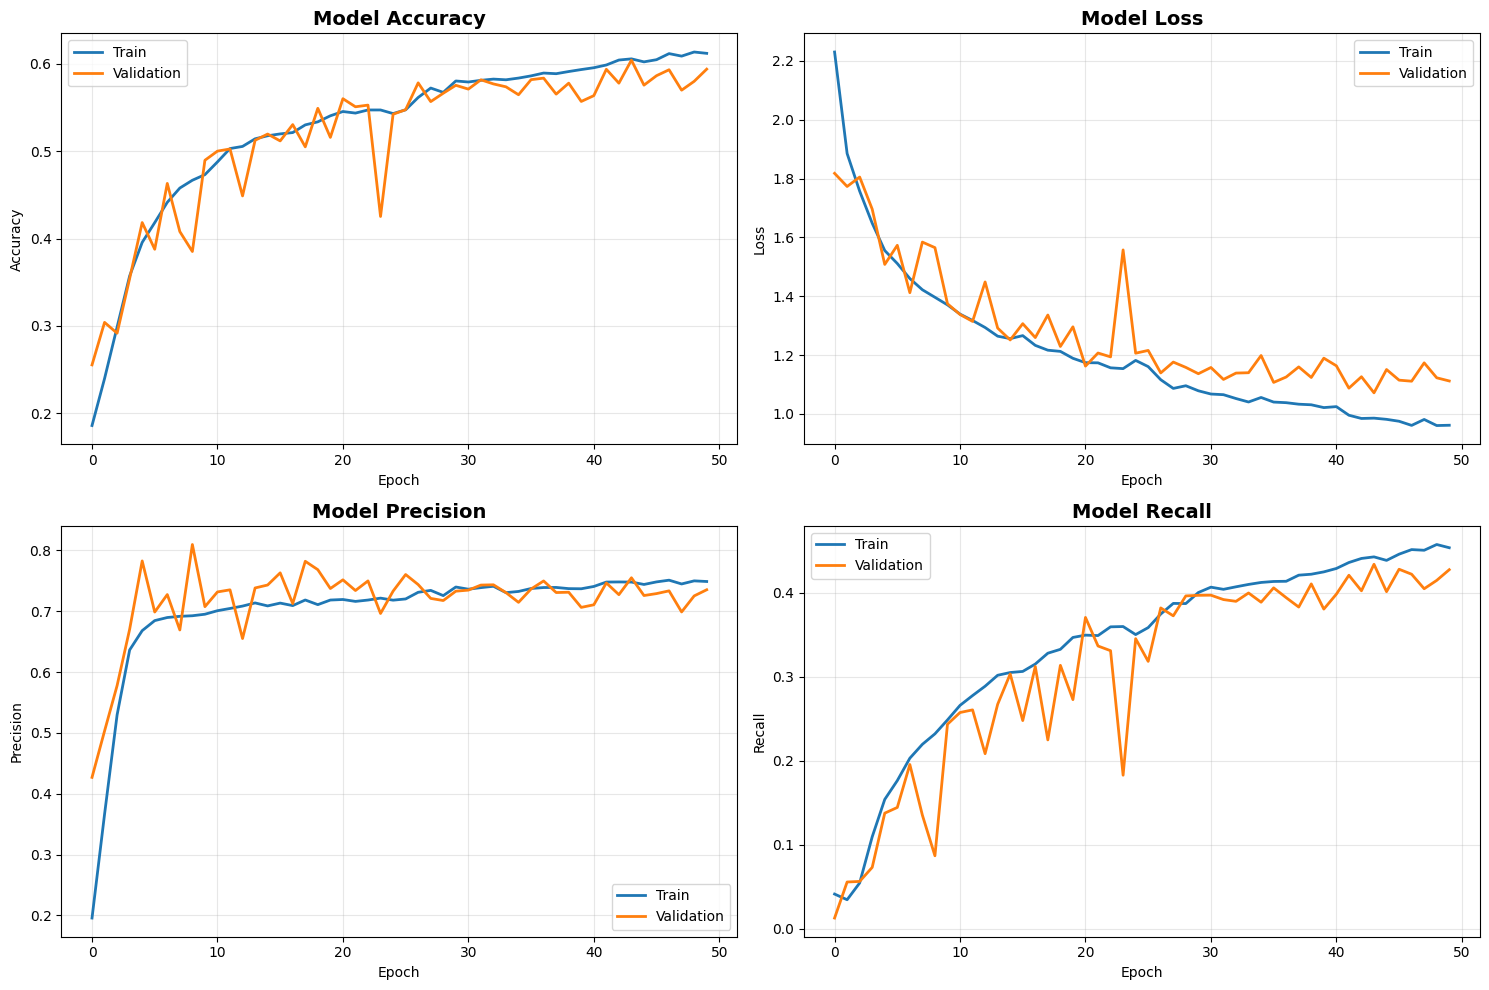

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
# plt.savefig('baseline_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 296ms/step - accuracy: 0.6221 - loss: 1.0171 - precision: 0.7526 - recall: 0.4752

Test Set Results:
  Loss: 1.0171
  Accuracy: 0.6221
  Precision: 0.7526
  Recall: 0.4752

Generating predictions for detailed analysis...
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.5570    0.5523    0.5546       956
     disgust     0.2408    0.7658    0.3664       111
        fear     0.5578    0.2688    0.3628      1023
       happy     0.8809    0.8173    0.8479      1773
     neutral     0.5611    0.6526    0.6034      1232
         sad     0.4819    0.5028    0.4921      1245
    surprise     0.6944    0.8359    0.7586       829

    accuracy                         0.6221      7169
   macro avg     0.5677    0.6279    0.5694      7169
weighted avg     0.6359    0.6221    0.6180      7169



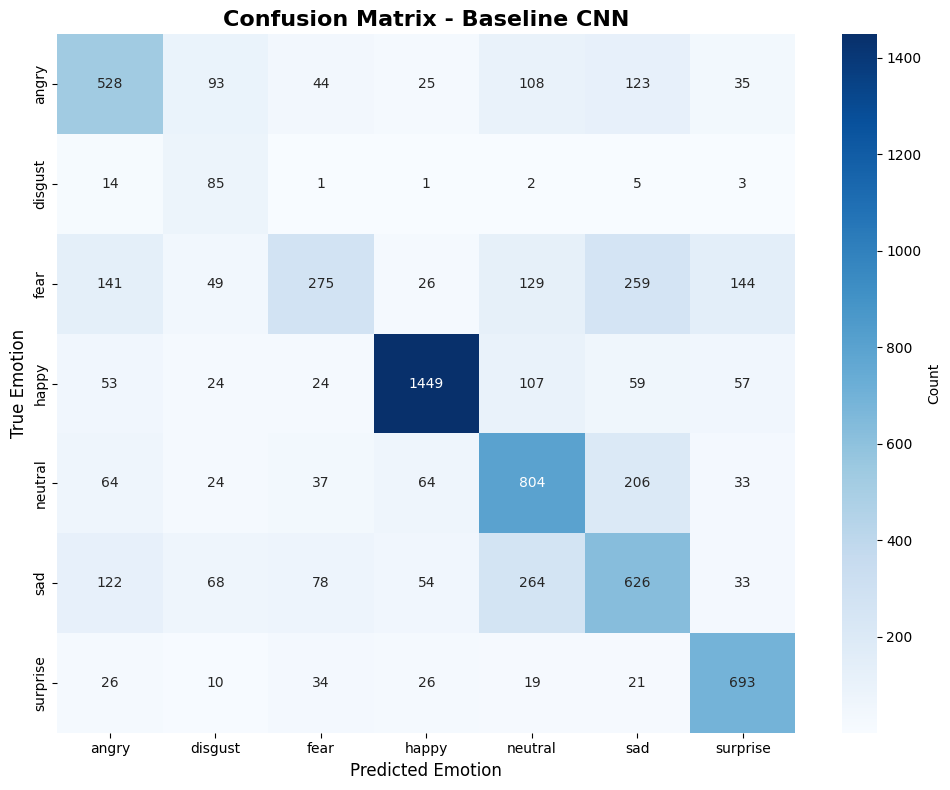


Per-Class Accuracy:
  Angry     : 0.5523 (528/956 correct)
  Disgust   : 0.7658 (85/111 correct)
  Fear      : 0.2688 (275/1023 correct)
  Happy     : 0.8173 (1449/1773 correct)
  Neutral   : 0.6526 (804/1232 correct)
  Sad       : 0.5028 (626/1245 correct)
  Surprise  : 0.8359 (693/829 correct)

BASELINE MODEL TRAINING COMPLETE!

Key Improvements Over Initial Model:
✓ Proper train/validation/test split (no data leakage)
✓ Class weighting for imbalance handling
✓ Optimized architecture for 48x48 images
✓ Comprehensive evaluation metrics
✓ Early stopping and learning rate scheduling


In [ ]:
# Evaluate on test set
test_results = model.evaluate(test_generator, verbose=1)

print("\nTest Set Results:")
print(f"  Loss: {test_results[0]:.4f}")
print(f"  Accuracy: {test_results[1]:.4f}")
print(f"  Precision: {test_results[2]:.4f}")
print(f"  Recall: {test_results[3]:.4f}")

# Generate predictions
print("\nGenerating predictions for detailed analysis...")
test_generator.reset()
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred_classes, target_names=EMOTIONS, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Baseline CNN', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.tight_layout()
plt.savefig('baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, emotion in enumerate(EMOTIONS):
    print(f"  {emotion.capitalize():10s}: {class_accuracy[idx]:.4f} ({int(cm[idx, idx])}/{int(cm.sum(axis=1)[idx])} correct)")

print("\n" + "="*70)
print("BASELINE MODEL TRAINING COMPLETE!")
print("="*70)

**ResNet18 Model**
